In [1]:
# import required modules
# data wrangling and types modules
import pandas as pd
from pandas import DataFrame
from typing import Dict, List
import numpy as np

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, SMOTEN
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, confusion_matrix, recall_score, precision_recall_curve, auc, roc_curve, log_loss
from sklearn.feature_selection import SelectKBest, chi2


from multiprocessing import Pool
from numpy import mean
from numpy import std
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb
import catboost as cat

from sklearn.metrics import matthews_corrcoef 
from sklearn.metrics import make_scorer
import time
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns


TODO

6. write algorithms
7. test and evaluate algorithms
8. use hydra for config management


## Importing Data and Data Exploration

This section deals with data imports and exploration.
The data is imported as a csv using pandas and converted to a pandas dataframe.
There are no null values within the dataset, there are 32769 entries in the dataset.
The distribution of access results, are Granted(1): 30872, Denied(0): 1897. 
This shows an imbalance in the dataset. The columns of the dataset all contain
integer values , but going by the dataset description, these integer values are
not real numbers but placeholders for categorical/identifying variables. They must
then be converted to strings in order to how have the number size influence
the machine models


In [2]:
# import data
amazon_data = pd.read_csv("./datasets/train.csv")

# check data details
amazon_data.info()

# check class distribution
amazon_data['ACTION'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


1    30872
0     1897
Name: ACTION, dtype: int64

In [3]:
# convert columns to strings because they are categorial/identifiers
amazon_data_wrang = amazon_data.astype(
                    {
                        "RESOURCE": str,
                        "MGR_ID": str,
                        "ROLE_ROLLUP_1": str,
                        "ROLE_ROLLUP_2": str,
                        "ROLE_DEPTNAME": str,
                        "ROLE_TITLE": str,
                        "ROLE_FAMILY_DESC": str,
                        "ROLE_FAMILY": str,
                        "ROLE_CODE": str
                    
                    }
)

amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


# Data Resampling

Before continuing with data exploration, due to the distribution of the data in this dataset; 16:1, 
for Access Granted versus Access denied, 
some resampling has to be done to make the data more balanced. This is done for various reasons, namely:
1. To improve the performance of the algorithm: when a machine learning model is trained on imbalanced data the 
experience of the model is usually skewed towards the majority class. In severe cases the model may not have any
discriminatory power concerning the minority class.
2. To make evaluation metrics more meaningful. When working with imbalanced datasets it is important to realise that
metrics such as accuracy, Mean Average Error can become misleading. The overwhelming nature of one class means that 
a model with 80% accuracy on a dataset with 8:1 distribution will be accurate on one class and have random behavior
on the minority class.
To resample a dataset, oversampling or undersampling can be used
Describe Oversampling and UnderSampling
Using an combination of the two here SMOTE and ENN(Edited Nearest Neighbors)

Explore the Data to see the distribution of the columns

Then Resample using imblearn to create pipeline of the features

In [4]:
# split data
X = amazon_data_wrang.drop(columns='ACTION', axis=1)
y = amazon_data_wrang['ACTION']

# train and test splits
train_X, Val_X, train_y, val_y = train_test_split(X, y, random_state=46)


In [5]:
model = DecisionTreeClassifier(random_state=46)
model.fit (train_X, train_y)
model_predictions = model.predict(Val_X)
roc_auc_score(val_y, model_predictions )


0.6762974669291317

In [6]:
# deffine resampling method
resample = SMOTEENN(smote=SMOTEN(sampling_strategy=0.1), enn=EditedNearestNeighbours(sampling_strategy='majority'), random_state=46)

# define pipeline
pipeline = Pipeline(steps=[('r', resample), ('m', model)])


In [7]:
pipeline.fit (train_X, train_y)
pipeline_model_predictions = pipeline.predict(Val_X)
log_loss(val_y, pipeline_model_predictions )

3.511657443169765

In [8]:
def check_resampling(sampling_strategy, train_x, train_y, test_x, test_y) -> int:

    resample = SMOTEENN(smote=SMOTEN(sampling_strategy=sampling_strategy), enn=EditedNearestNeighbours(sampling_strategy='majority'), random_state=46)

    pipeline = Pipeline(steps=[('r', resample), ('m', model)])

    pipeline.fit (train_x, train_y)
    pipeline_model_predictions = pipeline.predict(test_x)
    scores = log_loss(test_y, pipeline_model_predictions )
    return scores

In [9]:
Xj = amazon_data.drop(columns='ACTION', axis=1)
yj = amazon_data['ACTION']

amazon_train_x, amazon_val_x, amazon_train_y, amazon_val_y = train_test_split(Xj, yj, random_state=46, test_size=0.5)
# amazon_feat_x, amazon_feat_y = pipeline_feature_selection.fit_resample(amazon_train_x, amazon_train_y)

# amazon_experiment_data_X = select_features(data_split=amazon_feat_x)
# amazon_experiment_val_X = select_features(data_split=amazon_val_x)

# scoring_roc = check_resampling(0.2, amazon_train_x, amazon_train_y, amazon_val_x, amazon_val_y)

log_loss_results_list = []

for value in np.linspace(0.1, 1, 8, endpoint=False):
    scores = check_resampling(value, amazon_train_x, amazon_train_y, amazon_val_x, amazon_val_y)
    log_loss_results_list.append(scores)

print(log_loss_results_list)



[3.80909353248863, 3.880763620950016, 3.9650816591432676, 4.003026435549799, 4.475209108651576, 4.224360260994998, 4.066265452200493, 4.133719004344735]


<AxesSubplot:xlabel='strategy', ylabel='Log Loss'>

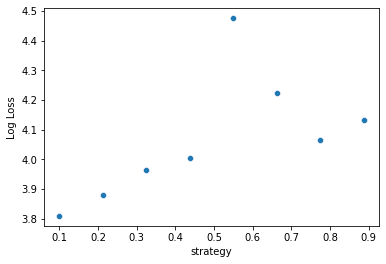

In [10]:
tested_strategy = np.linspace(0.1, 1, 8, endpoint=False).tolist()

df_sampling_strategy = pd.DataFrame(list(zip(tested_strategy, log_loss_results_list)),
               columns =['strategy', 'Log Loss'])

sns.scatterplot(data=df_sampling_strategy, x="strategy", y="Log Loss")


Text(0.5, 1.0, 'Count of values for ACTION variable')

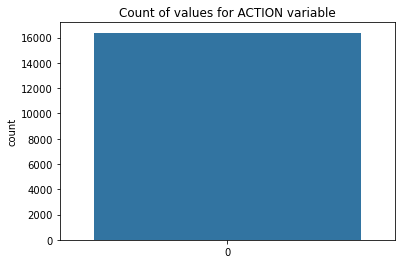

In [11]:
# Data Visualizations
sns.countplot(data=amazon_train_y)
plt.title('Count of values for ACTION variable')

## Feature selection
On this data set, we will use chi-squared feature selection method to choose the important four features in this dataset.

In [12]:
# define pipeline
pipeline_feature_selection = Pipeline(steps=[('r', resample)])
feat_x, feat_y = pipeline_feature_selection.fit_resample(train_X, train_y)
counter_1 = Counter(feat_y)
print(counter_1)

Counter({1: 19793, 0: 2316})


In [13]:
# perform feature selection to determine four best attributes
chi_squared_selector = SelectKBest(chi2, k=4)
chi_selected_X = chi_squared_selector.fit_transform(feat_x, feat_y)
selected_columns = feat_x.columns[(chi_squared_selector.get_support())]
print (feat_x.shape)
print(selected_columns)

(22109, 9)
Index(['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY'], dtype='object')


In [14]:
# TODO: implement Chinese wall policy.
# TODO: use streaming data to pass instances to the model and the Chinese wall policy
# TODO: ~~use CatBoost to deal with categorical data~~
# TODO: ~~use grid search for Catboost~~
# TODO: use SHAP for CatBoost
# TODO: Write Documentation for Implementation
# TODO: REname columns to fit research
# TODO: Add Brier loss to evaluation MEtrics, use it to replace Average precision or calculate average precision differently

In [15]:
def select_features(data_split: DataFrame) -> DataFrame:
    """
    A function which selects only the feature selected 
    columns from a data set

    Args:
        data_split(DataFrame): the data split being cleaned

    Returns:
        featured_dataset(DataFrame): the data set with only the feature selected columns
    """
    feature_selected_columns = ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY']
    featured_dataset = data_split[feature_selected_columns]
    return featured_dataset

    

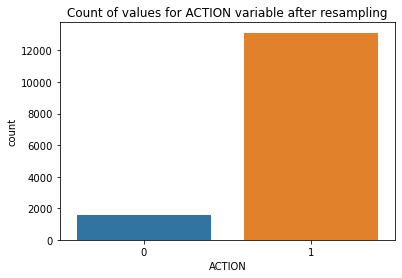

In [16]:
# Do visualizations

Xj = amazon_data.drop(columns='ACTION', axis=1)
yj = amazon_data['ACTION']

amazon_train_x, amazon_val_x, amazon_train_y, amazon_val_y = train_test_split(Xj, yj, random_state=46, test_size=0.5)
amazon_feat_x, amazon_feat_y = pipeline_feature_selection.fit_resample(amazon_train_x, amazon_train_y)

amazon_experiment_data_X = select_features(data_split=amazon_feat_x)
amazon_experiment_val_X = select_features(data_split=amazon_val_x)

# sns.countplot(data=amazon_data, x='ACTION')
# plt.title('Count of value for Action before resampling')

sns.countplot(x=amazon_feat_y)
plt.title('Count of values for ACTION variable after resampling');



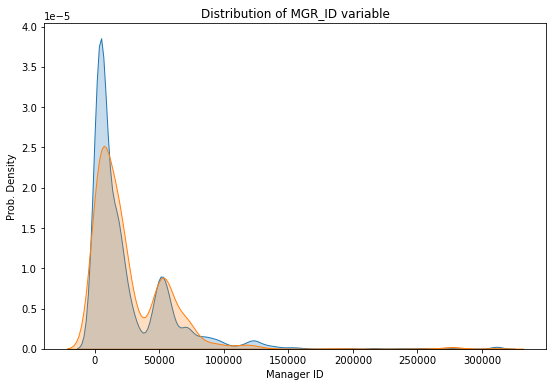

In [17]:
plt.figure(figsize=(9,6));
sns.kdeplot(data=amazon_data.query('ACTION == 1')['MGR_ID'],label='Accepted',shade=True);
sns.kdeplot(data=amazon_data.query('ACTION == 0')['MGR_ID'],label='Accepted',shade=True);

plt.title('Distribution of MGR_ID variable');
plt.xlabel('Manager ID');
plt.ylabel('Prob. Density');

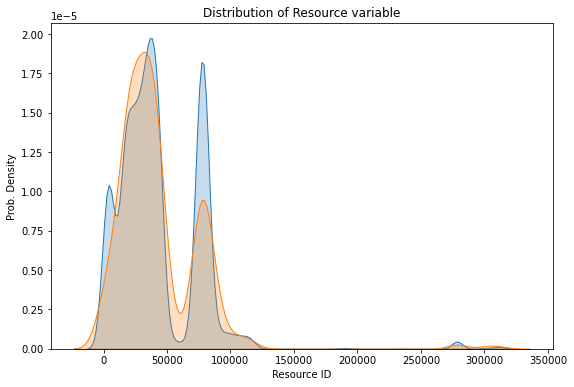

In [18]:
plt.figure(figsize=(9,6));
sns.kdeplot(data=amazon_data.query('ACTION == 1')['RESOURCE'],label='Accepted',shade=True);
sns.kdeplot(data=amazon_data.query('ACTION == 0')['RESOURCE'],label='Rejected',shade=True);

plt.title('Distribution of Resource variable');
plt.xlabel('Resource ID');
plt.ylabel('Prob. Density');

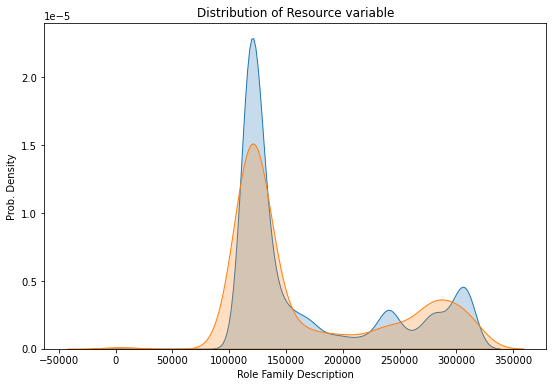

In [19]:
plt.figure(figsize=(9,6));
sns.kdeplot(data=amazon_data.query('ACTION == 1')['ROLE_FAMILY_DESC'],label='Accepted',shade=True);
sns.kdeplot(data=amazon_data.query('ACTION == 0')['ROLE_FAMILY_DESC'],label='Rejected',shade=True);

plt.title('Distribution of Resource variable');
plt.xlabel('Role Family Description');
plt.ylabel('Prob. Density');

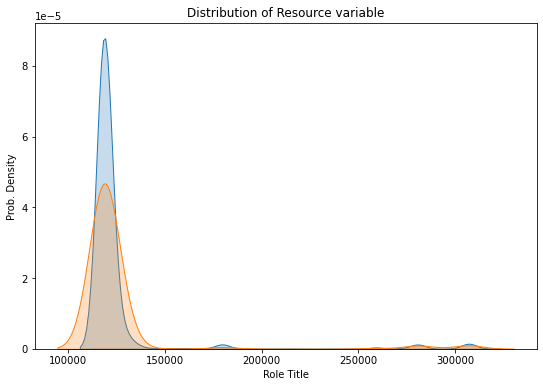

In [20]:
plt.figure(figsize=(9,6));
sns.kdeplot(data=amazon_data.query('ACTION == 1')['ROLE_TITLE'],label='Accepted',shade=True);
sns.kdeplot(data=amazon_data.query('ACTION == 0')['ROLE_TITLE'],label='Rejected',shade=True);

plt.title('Distribution of Resource variable');
plt.xlabel('Role Title');
plt.ylabel('Prob. Density');

In [21]:
def proposed_model(**kwargs):
    """
    Creates an instance of the proposed model with parameters
    specified

    Args:
        model's key word arguments

    Returns:
        XGB model instance
    """
    
    xgb_model  = xgb.XGBClassifier(**kwargs)
    
    return xgb_model


def cat_boost_model(**kwargs):
    """
    Creates an instance of the proposed model with parameters
    specified

    Args:
        model's key word arguments

    Returns:
        XGB model instance
    """

    cat_model = cat.CatBoostClassifier(**kwargs)
    
    
    return cat_model

In [22]:
def get_models(**kwargs) -> Dict:
    """
    A function that returns a dictionary containing
    models to be used for training and evaluation
    
    Args:
        kwargs: keyword arguments for the proposed model

    Returns:
        ml_models: a dictionary of instantiated machine learning models
    """


    #get a list of models to evaluate
    ml_models = dict()
    ml_models['lr'] = LogisticRegression()
    ml_models['knn'] = KNeighborsClassifier(n_neighbors=6)
    ml_models['cart'] = DecisionTreeClassifier()
    ml_models['svm'] = SVC()
    ml_models['naive_bayes'] = GaussianNB()
    ml_models['mlp'] = MLPClassifier()
    ml_models['randomforest'] = RandomForestClassifier()
    ml_models['adaboost'] = AdaBoostClassifier()
    ml_models['bagging'] = BaggingClassifier()
    ml_models['ensemble'] = cat_boost_model(**kwargs)

    return ml_models

In [23]:
# prepare data
Xj = amazon_data.drop(columns='ACTION', axis=1)
yj = amazon_data['ACTION']

amazon_train_x, amazon_val_x, amazon_train_y, amazon_val_y = train_test_split(Xj, yj, random_state=46, test_size=0.5)
amazon_feat_x, amazon_feat_y = pipeline_feature_selection.fit_resample(amazon_train_x, amazon_train_y)

amazon_experiment_data_X = select_features(data_split=amazon_feat_x)
amazon_experiment_val_X = select_features(data_split=amazon_val_x)


# dry_train_x, dry_val_x, dry_train_y, dry_val_y = train_test_split(amazon_feat_x, amazon_feat_y, random_state=46)
# amazon_experiment_data_X = select_features(data_split=dry_train_x)
# amazon_experiment_val_X = select_features(data_split=dry_val_x)
# counter_val = Counter(dry_val_y)
# print(counter_val)



# prep_train_x = select_features(feat_x)
# prep_val_x = select_features(Val_X)

# cat_data_X = prep_train_x.astype('category')
# cat_val_data_X = prep_val_x.astype('category')

# evaluate a given model
def evaluate_model(algorithm) -> Dict:
    """
    Function which evaluates machine learning models and saves
    results in a dictionary

    Args:
        algorithm: machine learning algorithm instance

    Returns:
        results_dict: results dictionary
    """
    results_dict = {}	
    
    
    algorithm.fit(amazon_experiment_data_X, amazon_feat_y)
    algorithm_predictions = algorithm.predict(amazon_experiment_val_X)
    auc_roc = roc_auc_score(amazon_val_y, algorithm_predictions)
    f1_score_result = f1_score(amazon_val_y, algorithm_predictions)
    avg_precision_score = average_precision_score(amazon_val_y, algorithm_predictions)
    true_neg_rate = recall_score(amazon_val_y, algorithm_predictions, pos_label = 0)
    false_pos_rate = 1- true_neg_rate

    results_dict['auc_roc'] = auc_roc
    results_dict['f1_score_result'] = f1_score_result
    results_dict['avg_precision_score'] = avg_precision_score
    results_dict['false_pos_rate'] = false_pos_rate

    return results_dict

def perform_analysis(learner) -> Dict:
    """
    A function which performs fit and predict for machine learning
    models and returns their results

    Args:
        learner- machine learning model instance

    Returns
        results_dict: dictionary of results
    """

   
    # results, names = list(), list()
    results = {}
    for name, algorithm in learner.items():
        scores = evaluate_model(algorithm)
        # results.append(scores)
        # names.append(name)
        results[name]  = scores
        
    return results

def record_keeping(performances) -> DataFrame:
    """
    A function that does record keeping of the performances
    of each model

    Args:
        performances: a dictionary of algorithms and scores
    """
    # test_time_dict = {}
    avg_precision_dict = {}
    auc_roc_dict = {}
    f1_score_dict = {}
    fpr_dict = {}

    for key, values in performances.items():
        # test_time_dict[key] = values['fit_time'].mean()
        f1_score_dict[key] = values['f1_score_result'].mean()
        auc_roc_dict[key] = values['auc_roc'].mean()
        fpr_dict[key] = values['false_pos_rate'].mean()
        avg_precision_dict[key] = values['avg_precision_score'].mean()
        
    result_frame = pd.DataFrame({   'F1Score':f1_score_dict,
                                    'AUCROC':auc_roc_dict,
                                    'AVGPrecision':avg_precision_dict,
                                    'FPR':fpr_dict})
    return result_frame

In [24]:
print(sklearn.metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [25]:
# implement analysis
# models_for_analysis = get_models(max_depth=4, objective="binary:logistic", 
#                                 n_estimators=50, tree_method="gpu_hist", 
#                                 eval_metric='auc', enable_categorical=True,
#                                 n_jobs=-1, use_label_encoder=False,
#                                  )


# cat_features = ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY']

# models_for_analysis = get_models(depth=4, l2_leaf_reg=1, learning_rate=0.1,
# cat_features=cat_features)


# analysis_results = perform_analysis(models_for_analysis)

# analysis_results_df = record_keeping(analysis_results)

# analysis_results_df



In [26]:
# # split data
# Xi = amazon_data_wrang.drop(columns='ACTION', axis=1)
# yi = amazon_data_wrang['ACTION']

# amazon_train_x, amazon_val_x, amazon_train_y, amazon_val_y = train_test_split(Xi, yi, random_state=46, stratify=yi)
# amazon_feat_x, amazon_feat_y = pipeline_feature_selection.fit_resample(amazon_train_x, amazon_train_y)

# dry_train_x, dry_val_x, dry_train_y, dry_val_y = train_test_split(amazon_feat_x, amazon_feat_y, random_state=46, stratify=amazon_feat_y)
# amazon_experiment_data_X = select_features(data_split=dry_train_x)
# amazon_experiment_val_X = select_features(data_split=dry_val_x)

# amazon_cat_x = amazon_experiment_data_X.astype('category')
# amazon_cat_val_x = amazon_experiment_val_X.astype('category')

# # xgb_model = xgb.XGBClassifier()

# # xgb_model  = proposed_model(objective="binary:logistic", 
# #                                 tree_method="gpu_hist", 
# #                                 eval_metric='aucpr', enable_categorical=True,
# #                                 n_jobs=-1, use_label_encoder=False)

# xgb_model = xgb.XGBClassifier()

# # start = time.perf_counter()
# # xgb_model.fit(amazon_cat_x, dry_train_y, 
# #                 eval_set=[(amazon_cat_x, dry_train_y), 
# #                 (amazon_cat_val_x, dry_val_y)], 
# #                 )
# # end = time.perf_counter()

# kfold = StratifiedKFold(shuffle=True, random_state=7)

# clf = GridSearchCV(xgb_model,
#                     {

#                         'tree_method': ["gpu_hist"],
#                         'enable_categorical': [True],
#                         'use_label_encoder': [False],
#                         'max_depth': [4,6,7],
#                         'n_estimators': [250, 300, 350],
#                         'objective': ["binary:logistic"],
#                         'eval_metric': ['auc'] 
#                     }, 
#                     scoring='roc_auc', verbose=1, n_jobs=-1, cv=kfold)

# # evals_result = xgb_model.evals_result()

# # print('')
# # print('Access complete dict:')
# # print(evals_result)

# n_estimators = [300, 350, 400]
# max_depth = [4, 6, 7]
# best_params = [{'enable_categorical': True, 'eval_metric': 'aucpr', 'max_depth': 10, 'n_estimators': 250, 'objective': 'binary:logistic',      'tree_method':    'gpu_hist', 'use_label_encoder': False}, 
#                 {'eval_metric': 'aucpr', 'max_depth': 10, 'n_estimators': 400, 'objective': 'binary:logistic'},
#                 {'eval_metric': 'aucpr', 'max_depth': 12, 'n_estimators': 500, 'objective': 'binary:logistic'}]
# best_acprc = [0.9073800050805165, 0.9260385465307127, 0.9216370452305271]



# clf.fit(amazon_cat_x, dry_train_y)
# print(clf.best_score_)
# print(clf.best_params_)

# # summarize results
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# params = clf.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))
# # plot results
# scores = np.array(means).reshape(len(max_depth), len(n_estimators))
# for i, value in enumerate(max_depth):
#     plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
# plt.legend()
# plt.xlabel('n_estimators')
# plt.ylabel('Average PR-Curve')
# # pyplot.savefig('n_estimators_vs_max_depth.png')

In [27]:

# # split data
# Xi = amazon_data_wrang.drop(columns='ACTION', axis=1)
# yi = amazon_data_wrang['ACTION']

# amazon_train_x, amazon_val_x, amazon_train_y, amazon_val_y = train_test_split(Xi, yi, random_state=46, stratify=yi)
# amazon_feat_x, amazon_feat_y = pipeline_feature_selection.fit_resample(amazon_train_x, amazon_train_y)

# dry_train_x, dry_val_x, dry_train_y, dry_val_y = train_test_split(amazon_feat_x, amazon_feat_y, random_state=46, stratify=amazon_feat_y)
# amazon_experiment_data_X = select_features(data_split=dry_train_x)
# amazon_experiment_val_X = select_features(data_split=dry_val_x)

# amazon_cat_x = amazon_experiment_data_X.astype('category')
# amazon_cat_val_x = amazon_experiment_val_X.astype('category')


# # cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# xgb_model = xgb.XGBClassifier(max_depth=4, objective="binary:logistic", 
#                                 n_estimators=50, tree_method="gpu_hist", 
#                                 eval_metric='auc', enable_categorical=True,
#                                 n_jobs=-1, use_label_encoder=False,)


# xgb_model.fit(amazon_cat_x, dry_train_y)
# yhat = xgb_model.predict(amazon_cat_val_x)


# # validate = cross_validate(xgb_model, amazon_cat_x, dry_train_y, scoring=scoring,
# #                              cv=cv, n_jobs=-1, error_score='raise')

# # predict probabilities
# xgb_probs = xgb_model.predict_proba(amazon_cat_val_x)

# # keep probabilities for the positive outcome only
# xgb_probs = xgb_probs[:, 1]
# lr_precision, lr_recall, _ = precision_recall_curve(dry_val_y, xgb_probs)

# xgb_model_aucprc = auc(lr_recall, lr_precision)

# # summarize scores
# print('Logistic: auc=%.3f' % (xgb_model_aucprc))

# # plot the precision-recall curves
# no_skill = len(dry_val_y[dry_val_y==1]) / len(dry_val_y)
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# plt.plot(lr_recall, lr_precision, marker='.', label='XGB Model')

# # axis labels
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# # show the legend
# plt.legend()
# # show the plot
# plt.show()


In [28]:
# # split data
# Xi = amazon_data_wrang.drop(columns='ACTION', axis=1)
# yi = amazon_data_wrang['ACTION']

# amazon_train_x, amazon_val_x, amazon_train_y, amazon_val_y = train_test_split(Xi, yi, random_state=46, stratify=yi)
# amazon_feat_x, amazon_feat_y = pipeline_feature_selection.fit_resample(amazon_train_x, amazon_train_y)

# dry_train_x, dry_val_x, dry_train_y, dry_val_y = train_test_split(amazon_feat_x, amazon_feat_y, random_state=46, stratify=amazon_feat_y)
# amazon_experiment_data_X = select_features(data_split=dry_train_x)
# amazon_experiment_val_X = select_features(data_split=dry_val_x)

# amazon_cat_x = amazon_experiment_data_X.astype('category')
# amazon_cat_val_x = amazon_experiment_val_X.astype('category')


# # cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# xgb_model = xgb.XGBClassifier(max_depth=4, objective="binary:logistic", 
#                                 n_estimators=50, tree_method="gpu_hist", 
#                                 eval_metric='auc', enable_categorical=True,
#                                 n_jobs=-1, use_label_encoder=False,)


# xgb_model.fit(amazon_cat_x, dry_train_y)
# yhat = xgb_model.predict(amazon_cat_val_x)

# # generate a no skill prediction (majority class)
# ns_probs = [0 for _ in range(len(dry_val_y))]


# # validate = cross_validate(xgb_model, amazon_cat_x, dry_train_y, scoring=scoring,
# #                              cv=cv, n_jobs=-1, error_score='raise')

# # predict probabilities
# xgb_probs = xgb_model.predict_proba(amazon_cat_val_x)

# # keep probabilities for the positive outcome only
# xgb_probs = xgb_probs[:, 1]

# # calculate scores
# ns_auc = roc_auc_score(dry_val_y, ns_probs)
# xgb_auc = roc_auc_score(dry_val_y, xgb_probs)

# # summarize scores
# print('No Skill: ROC AUC=%.3f' % (ns_auc))
# print('XGB Model: ROC AUC=%.3f' % (xgb_auc))


# # calculate roc curves
# ns_fpr, ns_tpr, _ = roc_curve(dry_val_y, ns_probs)
# xgb_fpr, xgb_tpr, _ = roc_curve(dry_val_y, xgb_probs)

# # plot the roc curve for the model
# plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGB Model')
# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # show the legend
# plt.legend()
# # show the plot
# plt.show()


Counter({1: 19793, 0: 2316})
Counter({1: 3267, 0: 391})
Counter({1: 9819, 0: 1152})
[0]	validation_0-error:0.09543	validation_0-auc:0.56247	validation_0-logloss:0.52563	validation_1-error:0.10853	validation_1-auc:0.49883	validation_1-logloss:0.53148
[1]	validation_0-error:0.09434	validation_0-auc:0.58506	validation_0-logloss:0.43586	validation_1-error:0.10935	validation_1-auc:0.49821	validation_1-logloss:0.44726
[2]	validation_0-error:0.09789	validation_0-auc:0.70858	validation_0-logloss:0.37630	validation_1-error:0.10744	validation_1-auc:0.54325	validation_1-logloss:0.39483
[3]	validation_0-error:0.09698	validation_0-auc:0.72015	validation_0-logloss:0.34278	validation_1-error:0.10798	validation_1-auc:0.54179	validation_1-logloss:0.36668
[4]	validation_0-error:0.09625	validation_0-auc:0.73402	validation_0-logloss:0.31971	validation_1-error:0.10744	validation_1-auc:0.54089	validation_1-logloss:0.35029
[5]	validation_0-error:0.09744	validation_0-auc:0.75263	validation_0-logloss:0.30553	v

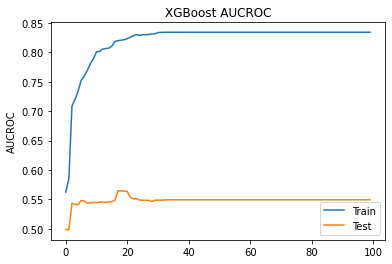

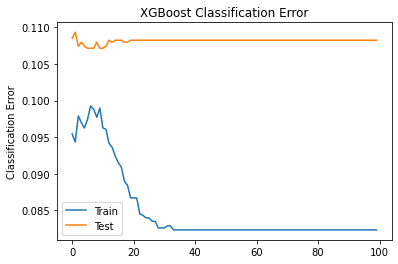

Text(0.5, 1.0, 'XGBoost Log loss')

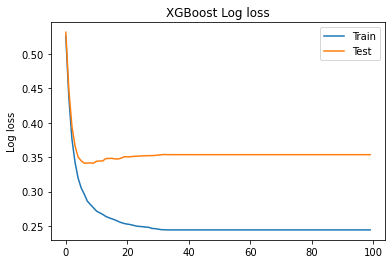

In [29]:
# split data
Xi = amazon_data_wrang.drop(columns='ACTION', axis=1)
yi = amazon_data_wrang['ACTION']

amazon_train_x, amazon_val_x, amazon_train_y, amazon_val_y = train_test_split(Xi, yi, random_state=46, test_size=0.5)
amazon_feat_x, amazon_feat_y = pipeline_feature_selection.fit_resample(amazon_train_x, amazon_train_y)
counter_test = Counter(feat_y)
print(counter_test)

dry_train_x, dry_val_x, dry_train_y, dry_val_y = train_test_split(amazon_feat_x, amazon_feat_y, random_state=46)
amazon_experiment_data_X = select_features(data_split=dry_train_x)
amazon_experiment_val_X = select_features(data_split=dry_val_x)
counter_val = Counter(dry_val_y)
print(counter_val)

counter_train = Counter(dry_train_y)
print(counter_train)

amazon_cat_x = amazon_experiment_data_X.astype('category')
amazon_cat_val_x = amazon_experiment_val_X.astype('category')

xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                               tree_method="gpu_hist",
                                eval_metric=['error', 'auc', 'logloss'], enable_categorical=True,
                                n_jobs=-1, use_label_encoder=False,)


xgb_model.fit(amazon_cat_x, dry_train_y,
              eval_set=[(amazon_cat_x, dry_train_y), 
                (amazon_cat_val_x, dry_val_y)])


# copy code
# make predictions for test data
y_pred = xgb_model.predict(amazon_cat_val_x)
predictions = [round(value) for value in y_pred]
# evaluate predictions
auc_roc = roc_auc_score(dry_val_y, predictions)
print("AUCROC: %.2f%%" % (auc_roc))
# retrieve performance metrics
results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUCROC')
plt.title('XGBoost AUCROC')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log loss')
plt.title('XGBoost Log loss')





In [30]:

# # split data
# Xi = amazon_data.drop(columns='ACTION', axis=1)
# yi = amazon_data['ACTION']

# amazon_train_x, amazon_val_x, amazon_train_y, amazon_val_y = train_test_split(Xi, yi, random_state=46, test_size=0.5)
# amazon_feat_x, amazon_feat_y = pipeline_feature_selection.fit_resample(amazon_train_x, amazon_train_y)
# counter_test = Counter(feat_y)
# print(counter_test)

# dry_train_x, dry_val_x, dry_train_y, dry_val_y = train_test_split(amazon_feat_x, amazon_feat_y, random_state=46)
# amazon_experiment_data_X = select_features(data_split=dry_train_x)
# amazon_experiment_val_X = select_features(data_split=dry_val_x)
# counter_val = Counter(dry_val_y)
# print(counter_val)

# counter_train = Counter(dry_train_y)
# print(counter_train)

# amazon_cat_x = amazon_experiment_data_X.astype('category')
# amazon_cat_val_x = amazon_experiment_val_X.astype('category')

# cat_features = ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY']

# cat_model = cat.CatBoostClassifier(iterations=50,
#                            verbose=True,custom_metric=['AUC', 'Logloss'],
#                            cat_features=cat_features)


# cat_model.fit(amazon_experiment_data_X, dry_train_y, eval_set=(amazon_experiment_val_X, dry_val_y), silent=True)


# # copy code
# # make predictions for test data
# y_pred = cat_model.predict(amazon_cat_val_x)
# predictions = [round(value) for value in y_pred]
# # evaluate predictions
# auc_roc = roc_auc_score(dry_val_y, predictions)
# print("AUCROC: %.2f%%" % (auc_roc))
# # retrieve performance metrics
# results = cat_model.get_evals_result()
# # print(results)
# epochs = len(results['validation']['Logloss'])
# x_axis = range(0, epochs)
# # plot AUCROC
# # fig, ax = plt.subplots()
# # ax.plot(x_axis, results['learn']['AUC'], label='Train')
# # ax.plot(x_axis, results['validation']['AUC'], label='Test')
# # ax.legend()
# # plt.ylabel('AUCROC')
# # plt.title('XGBoost AUCROC')
# # plt.show()
# # # plot classification error
# # fig, ax = plt.subplots()
# # ax.plot(x_axis, results['validation_0']['error'], label='Train')
# # ax.plot(x_axis, results['validation_1']['error'], label='Test')
# # ax.legend()
# # plt.ylabel('Classification Error')
# # plt.title('XGBoost Classification Error')
# # plt.show()
# # plot log loss
# fig, ax = plt.subplots()
# ax.plot(x_axis, results['learn']['Logloss'], label='Train')
# ax.plot(x_axis, results['validation']['Logloss'], label='Test')
# ax.legend()
# plt.ylabel('Log loss')
# plt.title('XGBoost Log loss')

In [31]:
# # split data
# Xi = amazon_data.drop(columns='ACTION', axis=1)
# yi = amazon_data['ACTION']

# amazon_train_x, amazon_val_x, amazon_train_y, amazon_val_y = train_test_split(Xi, yi, random_state=46, test_size=0.5)
# amazon_feat_x, amazon_feat_y = pipeline_feature_selection.fit_resample(amazon_train_x, amazon_train_y)
# counter_test = Counter(feat_y)
# print(counter_test)

# dry_train_x, dry_val_x, dry_train_y, dry_val_y = train_test_split(amazon_feat_x, amazon_feat_y, random_state=46)
# amazon_experiment_data_X = select_features(data_split=dry_train_x)
# amazon_experiment_val_X = select_features(data_split=dry_val_x)
# counter_val = Counter(dry_val_y)
# print(counter_val)

# counter_train = Counter(dry_train_y)
# print(counter_train)

# amazon_cat_x = amazon_experiment_data_X.astype('category')
# amazon_cat_val_x = amazon_experiment_val_X.astype('category')

# cat_features = ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY']

# model = cat.CatBoost(params={'cat_features': cat_features})

# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9],
#         }

# grid_search_result = model.grid_search(grid, 
#                                        X=amazon_experiment_data_X, 
#                                        y=dry_train_y,
#                                        )

# print(grid_search_result['params'])
# best_params = {'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.1}